In [21]:
# Import core libraries for data manipulation and visualization
from matplotlib.pyplot import subplots  # For creating figure and axis objects for plotting
import numpy as np  # Numerical computing library for array operations
import pandas as pd  # Data manipulation library for DataFrames
from ISLP.models import ModelSpec as MS  # Model specification tool for creating design matrices
from ISLP import load_data  # Utility to load datasets from ISLP package

from lifelines import \
     (KaplanMeierFitter,  # Fits Kaplan-Meier survival curves (non-parametric estimator)
      CoxPHFitter)  # Fits Cox Proportional Hazards models (semi-parametric regression)
from lifelines.statistics import \
     (logrank_test,  # Tests equality of survival curves between 2 groups
      multivariate_logrank_test)  # Tests equality of survival curves among 3+ groups
from ISLP.survival import sim_time  # Simulates survival times based on Cox model assumptions
import warnings
warnings.filterwarnings("ignore")


Data Generation

In [3]:
# Set random seed for reproducibility (following ISLP lab convention)
rng = np.random.default_rng(2025)

# Simulate 500 employees hired over a 5-year period
n_employees = 500

# Department assignment (5 departments with realistic proportions)
# Engineering is largest, HR smallest (typical for tech companies)
departments = rng.choice(
    ['Engineering', 'Sales', 'Marketing', 'HR', 'Operations'], 
    size=n_employees, 
    p=[0.40, 0.25, 0.18, 0.08, 0.09]
)

# Years of prior work experience at hire (0-20 years)
# Use exponential distribution to create right-skewed realistic experience levels
experience = rng.exponential(scale=4.5, size=n_employees)
experience = np.clip(experience, 0, 20)

# Performance rating (1.0-5.0 scale, where higher is better)
# Centered at 3.5 with standard deviation of 0.7 to create realistic distribution
performance = rng.normal(loc=3.5, scale=0.7, size=n_employees)
performance = np.clip(performance, 1.0, 5.0)

# Starting salary in thousands (correlated with experience and department)
# Different departments have different base salary structures
dept_salary_base = {
    'Engineering': 95,  # Highest base (competitive tech market)
    'Sales': 72,        # Lower base but typically has commission
    'Marketing': 78,    # Moderate base
    'HR': 68,           # Lower base
    'Operations': 85    # Good base (technical operations)
}
base_salary = np.array([dept_salary_base[d] for d in departments])
# Add experience premium (~$2.5k per year) plus random variation
salary = base_salary + 2.5 * experience + rng.normal(0, 8, n_employees)
salary = np.clip(salary, 45, 160)

# Remote work assignment (binary: 1 = remote, 0 = on-site)
# Engineering has highest remote proportion, Operations lowest
remote_prob = np.where(
    departments == 'Engineering', 0.60,  # Engineering: 60% remote
    np.where(departments == 'Operations', 0.15,  # Operations: 15% remote
             np.where(departments == 'Sales', 0.40,  # Sales: 40% remote
                     np.where(departments == 'Marketing', 0.45, 0.35)))  # Marketing: 45%, HR: 35%
)
remote_work = rng.binomial(1, remote_prob)

print("Covariates generated successfully!")
print(f"Sample size: {n_employees} employees")
print(f"Remote work proportion: {remote_work.mean():.1%}")

Covariates generated successfully!
Sample size: 500 employees
Remote work proportion: 45.2%


In [4]:
# Simulate employment duration (time until departure) using Cox model structure
# Different departments have different baseline retention patterns
dept_hazard_effects = {
    'Engineering': -0.40,   # Best retention (negative = lower hazard)
    'Sales': 0.45,          # Worst retention (positive = higher hazard)
    'Marketing': 0.18,      # Moderate-poor retention
    'HR': 0.08,             # Moderate retention
    'Operations': -0.25     # Good retention
}
dept_effect = np.array([dept_hazard_effects[d] for d in departments])

# Calculate hazard rate (risk of leaving) based on multiple factors
# Cox model structure: λ(t) = λ₀(t) × exp(β₁X₁ + β₂X₂ + ...)
# Protective factors (negative coefficients): experience, performance, salary, remote work
log_hazard = (
    dept_effect +                          # Department effect
    -0.10 * experience +                   # Each year experience reduces hazard by 9.5% (exp(-0.10)≈0.905)
    -0.40 * (performance - 3.5) +          # Higher performance is strongly protective
    -0.018 * (salary - 85) +               # Higher salary reduces departure risk
    -0.35 * remote_work +                  # Remote work reduces hazard by 30% (exp(-0.35)≈0.70)
    -1.5                                   # Baseline log-hazard
)
lambda_hazard = np.exp(log_hazard)  # Convert to hazard rate

# Generate time to departure from exponential distribution (months)
# Exponential distribution is memoryless and commonly used in survival simulation
time_to_departure = rng.exponential(scale=1/lambda_hazard, size=n_employees)

# Add administrative censoring (employees still at company at study end)
# Study duration varies by employee (12-60 months observation window)
# This creates realistic Type I censoring
study_duration = rng.uniform(low=12, high=60, size=n_employees)

# Observed time is minimum of departure time and censoring time
observed_time = np.minimum(time_to_departure, study_duration)
# Event indicator: 1 = departed (event observed), 0 = still employed (censored)
event_indicator = (time_to_departure <= study_duration).astype(int)

print(f"Survival times generated!")
print(f"Events (departures): {event_indicator.sum()}")
print(f"Censored (still employed): {(1 - event_indicator).sum()}")
print(f"Censoring rate: {(1 - event_indicator).mean():.1%}")

Survival times generated!
Events (departures): 433
Censored (still employed): 67
Censoring rate: 13.4%


In [5]:
# Create final DataFrame with all variables
retention_data = pd.DataFrame({
    'time': observed_time,                    # Employment duration in months
    'event': event_indicator,                 # 1 = left company, 0 = still employed
    'department': pd.Categorical(departments), # Department (categorical)
    'experience': experience,                 # Years of prior experience (continuous)
    'performance': performance,               # Performance rating 1-5 (continuous)
    'salary': salary,                         # Starting salary in thousands (continuous)
    'remote_work': remote_work                # 1 = remote, 0 = on-site (binary)
})

print("=" * 70)
print("EMPLOYEE RETENTION DATASET CREATED")
print("=" * 70)
print(f"Dataset dimensions: {retention_data.shape[0]} employees × {retention_data.shape[1]} variables")
print(f"\nFirst 10 observations:")
print(retention_data.head(10))

EMPLOYEE RETENTION DATASET CREATED
Dataset dimensions: 500 employees × 7 variables

First 10 observations:
        time  event   department  experience  performance      salary  \
0   4.137837      1   Operations    0.841920     2.655509   92.316205   
1   3.282764      1  Engineering    0.946957     3.380019   92.603354   
2  18.432079      1    Marketing    9.409169     2.735693   98.144888   
3   4.663205      1           HR    5.583752     2.030922   76.167897   
4   2.323511      1   Operations    0.686558     3.539874   79.926189   
5  14.018088      1  Engineering    2.070775     3.140689  104.693788   
6  39.645606      0  Engineering   15.157682     4.367160  138.590670   
7   4.476022      1   Operations    3.327090     3.320088   81.560671   
8   4.057824      1    Marketing    2.883564     3.737368   96.047723   
9  16.240357      0  Engineering   15.727998     3.492641  123.907938   

   remote_work  
0            0  
1            1  
2            1  
3            1  
4   

## Question 1

In [8]:
#load data
data = retention_data.copy()
data.describe(include='all')


,time,event,department,experience,performance,salary,remote_work
count,500.000000,500.000000,500,500.000000,500.000000,500.000000,500.000000
unique,NaN,NaN,5,NaN,NaN,NaN,NaN
top,NaN,NaN,Engineering,NaN,NaN,NaN,NaN
freq,NaN,NaN,194,NaN,NaN,NaN,NaN
mean,10.339598,0.866000,NaN,4.284919,3.452507,93.746751,0.452000
std,11.332352,0.340993,NaN,4.170704,0.660430,16.430186,0.498189
min,0.005248,0.000000,NaN,0.008826,1.000000,54.329336,0.000000
25%,2.256432,1.000000,NaN,1.239732,3.052519,81.552871,0.000000
50%,6.298536,1.000000,NaN,3.092920,3.447376,93.424841,0.000000
75%,14.660414,1.000000,NaN,5.902214,3.868776,104.411944,1.000000


In [12]:
print('Distribution of employees across departments:')
print(data['department'].value_counts())
print('==============================')
print('Number of departures:')
print(data['event'].value_counts())
print('==============================')
print('Number of departures vs censored across departments:')
print(pd.crosstab(data['department'], data['event'], rownames=['Department'], colnames=['Event (0=Censored, 1=Departure)']))

Distribution of employees across departments:
department
Engineering    194
Sales          122
Marketing       93
Operations      54
HR              37
Name: count, dtype: int64
Number of departures:
event
1    433
0     67
Name: count, dtype: int64
Number of departures vs censored across departments:
Event (0=Censored, 1=Departure)   0    1
Department                              
Engineering                      48  146
HR                                1   36
Marketing                         7   86
Operations                        7   47
Sales                             4  118


In [17]:
# Fit a Kaplan-Meier estimator for overall employee retention
km = KaplanMeierFitter()
km_departure = km.fit(data['time'], event_observed=data['event'], label='Overall Employee Retention')


<Axes: xlabel='timeline'>

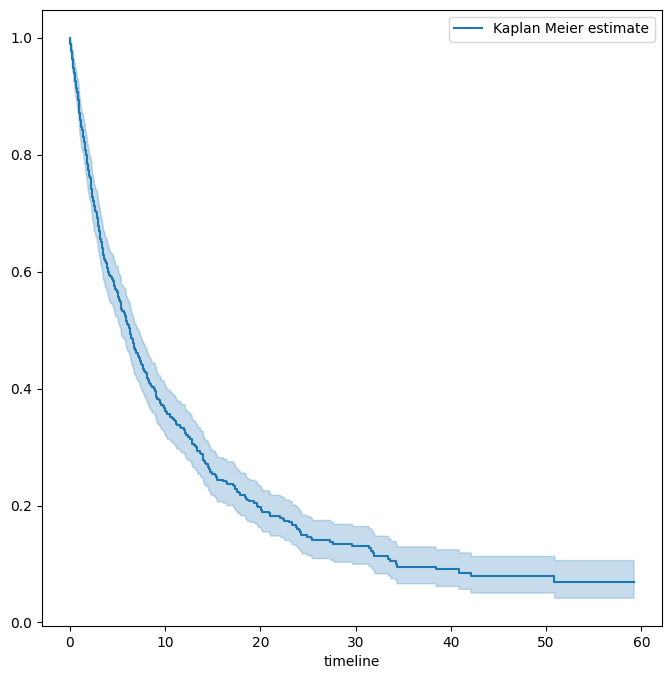

In [16]:
# Create a survival plot with shaded confidence intervals.
fig, ax = subplots(figsize=(8,8)) 
km_departure.plot(label='Kaplan Meier estimate', ax=ax)

In [23]:
# Report the following: Median retention time (if estimable), 25th and 75th percentile retention times, Retention probability at 12, 24, and 48 months
print(f"Median retention time (months): {km_departure.median_survival_time_:.2f}")
print(f"25th percentile retention time (months): {km_departure.percentile(0.25):.2f}")  
print(f"75th percentile retention time (months): {km_departure.percentile(0.75):.2f}")
print(f"Retention probability at 12 months: {km_departure.survival_function_at_times(12).values[0]:.2f}")
print(f"Retention probability at 24 months: {km_departure.survival_function_at_times(24).values[0]:.2f}")
print(f"Retention probability at 48 months: {km_departure.survival_function_at_times(48).values[0]:.2f}")

Median retention time (months): 6.29
25th percentile retention time (months): 15.34
75th percentile retention time (months): 2.26
Retention probability at 12 months: 0.33
Retention probability at 24 months: 0.16
Retention probability at 48 months: 0.08


The results from the Kaplan-Meier estimator tell us that $\frac{2}{3}$ of the new employees won't stay in the company for more than 1 year, and only about 16% will remain after 2 years. This indicates a high turnover rate among new employees, suggesting potential issues with job satisfaction, onboarding processes, or company culture that may need to be addressed to improve retention.

## Question 2

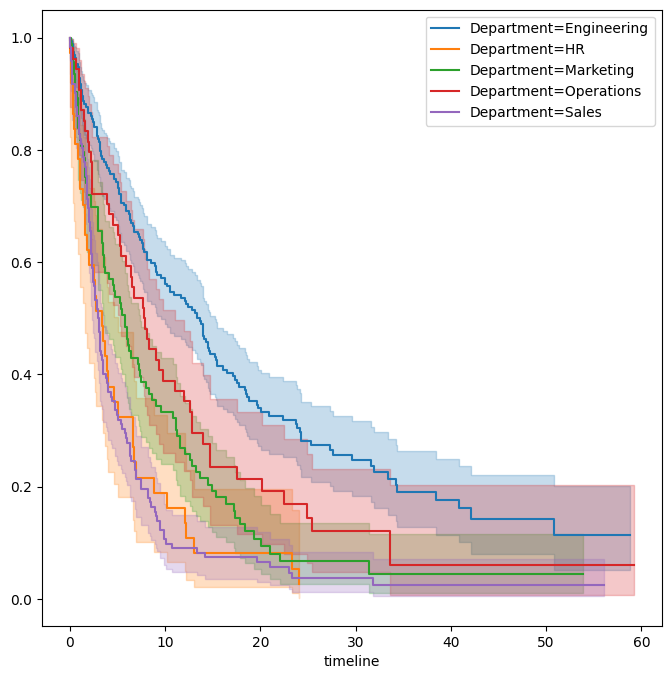

In [29]:
# Create stratified Kaplan-Meier curves by departments
fig, ax = subplots(figsize=(8,8))
by_Department = {}  # Dictionary to store data for each department (for later log-rank test)
# groupby('department') splits data into different department groups
for Department, df in data.groupby('department'):
    by_Department[Department] = df  # Store the subset for this department
    km_Department = km.fit(df['time'], df['event'])  # Fit K-M curve for this department
    km_Department.plot(label='Department=%s' % Department, ax=ax)

In [33]:
# Create a formatted table reporting median retention time for each department.

median_table = pd.DataFrame(columns=['Department', 'Median Retention Time (months)'])
for Department, df in by_Department.items():
    km_Department = km.fit(df['time'], df['event'])
    median_time = km_Department.median_survival_time_
    new_row = pd.DataFrame({
        'Department': [Department],
        'Median Retention Time (months)': [f"{median_time:.2f}"]
    })
    median_table = pd.concat([median_table, new_row], ignore_index=True)
median_table

,Department,Median Retention Time (months)
0,Engineering,13.37
1,HR,3.35
2,Marketing,5.78
3,Operations,7.80
4,Sales,2.99


The department with highest retention is the engineering department, and the sales department is the one with the lowest retention.
The Kaplan-Meier curves of these 2 department actually act differently at the very beginning. The engineering department shows a high retention rate right from the start, while the sales department experiences a sharp decline in retention within the first few months. 

This suggests that employees in the engineering department may find their roles more satisfying or better aligned with their expectations compared to those in the sales department, who may face challenges that lead to early departures.

## Question 3

In [34]:
# Perform a log-rank test comparing retention across all five departments
result = multivariate_logrank_test(data['time'], data['department'], data['event'])
print(result)

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          90.11 <0.005     59.48


In [35]:
# Calculate the difference in median retention (in months) between the highest and lowest retention departments, express this difference as a percentage
median_retention = data.groupby('department')['time'].median()
diff_median = median_retention.max() - median_retention.min()
percent_diff = (diff_median / median_retention.min()) * 100
print(f"Difference in median retention (months): {diff_median}")
print(f"Percentage difference in median retention: {percent_diff:.2f}%")

Difference in median retention (months): 10.354308674394046
Percentage difference in median retention: 344.08%


The log-rank test results indicate a significant difference in survival distributions between the departments (p-value < 0.05). This suggests that the department an employee belongs to has a statistically significant impact on their retention time at the company. Further investigation into department-specific factors may be necessary to understand the underlying causes of these differences.

## Question 4

In [36]:
# Fit a Cox proportional hazards model predicting time until departure using all predictors
coxph = CoxPHFitter
cleaned = data.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)

fit_all = coxph().fit(all_df,
                      'time',
                      'event')

In [39]:
# Create and display a comprehensive results table. 
results_table = fit_all.summary[['coef', 'se(coef)', 'p']].copy()
results_table['coef'] = results_table['coef'].round(3)
results_table['se(coef)'] = results_table['se(coef)'].round(3)
results_table['p'] = results_table['p'].round(3)
results_table


,coef,se(coef),p
covariate,,,
department[HR],0.759,0.242,0.002
department[Marketing],0.542,0.167,0.001
department[Operations],0.247,0.181,0.173
department[Sales],0.943,0.188,0.000
experience,-0.090,0.020,0.000
performance,-0.213,0.076,0.005
salary,-0.021,0.006,0.001
remote_work,-0.516,0.102,0.000


In [42]:
# Report and interpret the model's concordance index (C-index)
c_index = fit_all.concordance_index_
print(f"C-index of the Cox model: {c_index:.3f}")

C-index of the Cox model: 0.705


The C-index of the Cox model tells us that the model has about 70% accuracy in predicting the order of employee departures based on the included predictors. This indicates that the model is reasonably effective at distinguishing between employees who are likely to leave sooner versus those who are likely to stay longer, although there is still room for improvement in predictive performance.

In [43]:
# For each significant continuous predictor, compute hazard ratios for meaningful changes, interpret what each hazard ratio means in practical terms
significant_vars = fit_all.summary[fit_all.summary['p'] < 0.05].index
significant_vars

Index(['department[HR]', 'department[Marketing]', 'department[Sales]',
       'experience', 'performance', 'salary', 'remote_work'],
      dtype='object', name='covariate')

In [45]:
for var in significant_vars:
    if var in ['experience', 'performance', 'salary']:
        coef = fit_all.params_[var]
        if var == 'experience':
            change = 5  # 5-year increase
            hr = np.exp(coef * change)
            print(f"Hazard Ratio for a 5-year increase in experience: {hr:.3f}")
            print(f"Interpretation: A 5-year increase in experience is associated with a {((hr - 1) * 100):.2f}% change in the hazard of departure.")
        elif var == 'performance':
            change = 1  # 1-point increase
            hr = np.exp(coef * change)
            print('==============================')
            print(f"Hazard Ratio for a 1-point increase in performance: {hr:.3f}")
            print(f"Interpretation: A 1-point increase in performance rating is associated with a {((hr - 1) * 100):.2f}% change in the hazard of departure.")
        elif var == 'salary':
            change = 10  # $10k increase
            hr = np.exp(coef * change)
            print('==============================')
            print(f"Hazard Ratio for a $10k increase in salary: {hr:.3f}")
            print(f"Interpretation: A $10k increase in starting salary is associated with a {((hr - 1) * 100):.2f}% change in the hazard of departure.")

Hazard Ratio for a 5-year increase in experience: 0.638
Interpretation: A 5-year increase in experience is associated with a -36.16% change in the hazard of departure.
Hazard Ratio for a 1-point increase in performance: 0.808
Interpretation: A 1-point increase in performance rating is associated with a -19.21% change in the hazard of departure.
Hazard Ratio for a $10k increase in salary: 0.808
Interpretation: A $10k increase in starting salary is associated with a -19.24% change in the hazard of departure.


All these significant continuous variables (experience, performance, salary) show protective effects (HR < 1.0), meaning higher experience, performance, and salary all reduce the risk of employee departure.

A 5-year increase in experience is associated with a -36.16% change in the hazard of departure; a 1-point increase in performance rating is associated with a -19.21% change in the hazard of departure; and a $10k increase in starting salary is associated with a -19.24% change in the hazard of departure.

And the C-index of the Cox model is about 0.70, indicating that the model has reasonable predictive accuracy in distinguishing between employees who are likely to leave sooner versus those who are likely to stay longer.